In [1]:
# Python libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import jaccard_score
from sklearn.calibration import CalibrationDisplay
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [2]:
# Personal libraries

# Some of these modules were created for my backtester and also included therein
# See https://github.com/stevetulig/Backtester-with-Tkinter-based-GUI.git

from ZenithDatabaseInteractions import connectZenithDb, connectZenithDb_v2, extractIndexData
from PortfolioStuff import getPortfolios, calcAllPortfolioValues, \
    calcPortfolioReturns, calcPerformanceStats, plotPortfolioValues

# Other modules created specifically for this application
#from extractYearData import extractYearData

In [32]:
def extractYearData(forecastYear, cnxn):
    # extract all financial ratios
    strQry1='select a.*, ' +str(forecastYear)+' as ForecastYear from outputTable a inner join financialRefDates b ' + \
            'on a.StockID=b.StockID and a.ReportMonth=month(b.reportDate) ' + \
            'and a.ReportYear=year(b.reportDate)-1900 ' + \
            'where year(b.rebalanceDate)=' + str(forecastYear-1)
    df1=pd.read_sql(strQry1,cnxn)

    # extract market-based ratios
    strQry2='select * from outputTableMktBased where year(monthEnd)=' + str(forecastYear-1) + ' and month(monthEnd)=12'
    df2=pd.read_sql(strQry2,cnxn)

    # merge financial and market-based features
    features=df1.merge(df2,on='StockID')
    features.drop(columns=['ReportMonth', 'ReportYear', 'monthEnd'],inplace=True)
    #features.dropna(axis=0,inplace=True)

    # limit study to companies in the top 500 by market cap
    features=features[features.MCR<501]

    # extract the industry of each stock and exclude real estate and financial companies
    strQry3='select StockID, IndustryNo from companysectors'
    df3=pd.read_sql(strQry3,cnxn)
    df3.dropna(inplace=True)
    inds=df3.astype({'IndustryNo': 'int32'})
    features=features.merge(inds,on='StockID')

    # exclude real estate (IndustryNo=1) and financial (IndustryNo=5) stocks
    features=features[(features['IndustryNo']!=1) & (features['IndustryNo']!=5)]
    features.drop(columns=['IndustryNo'],inplace=True)

    # extract stock returns
    # first, the TR index from end of December in the previous year
    strQry4='select StockID, AccumIndex as TR0 from stockaccumindex where PriceDate='+\
            '(select max(PriceDate) from tradingdays where year(PriceDate)='+str(forecastYear-1)+')'
    df4=pd.read_sql(strQry4,cnxn)
    # next, the TR index from end of December in the forecast year
    strQry5='select StockID, AccumIndex as TR1 from stockaccumindex where PriceDate='+\
            '(select max(PriceDate) from tradingdays where year(PriceDate)='+str(forecastYear)+')'
    df5=pd.read_sql(strQry5,cnxn)
    # merge the 2 dataframes
    stockReturns=df4.merge(df5,on='StockID')
    stockReturns['Return']=stockReturns['TR1']/stockReturns['TR0']-1
    stockReturns.drop(columns=['TR0','TR1'],inplace=True)
    allData=features.merge(stockReturns,on='StockID')

    # create the target variable: HighReturn=1 if the stock return is above the median
    allData['HighReturn']=0
    allData.loc[allData.Return>allData['Return'].median(),'HighReturn']=1
    
    #trim outliers; as defined per standard box plot definition (i.e. outside of 1st & 3rd quartiles +/- 1.5* interquartile range)
    tempdf=allData.drop(columns=['StockID', 'ForecastYear', 'HighReturn'])
    q1=tempdf.quantile(0.25)
    q3=tempdf.quantile(0.75)
    iqr=q3-q1
    lower=q1-1.5*iqr
    upper=q3+1.5*iqr
    desc=pd.concat([q1,q3,iqr,lower,upper],axis=1).T
    desc.rename(index={0.25: 'q1', 0.75: 'q3', 0: 'iqr', 1:'lower', 2:'upper'},inplace=True)

    for v in tempdf.columns.values: # exclude 'Outperform'
            allData[v]=np.where(allData[v]>desc[v]['upper'],desc[v]['upper'],np.where(allData[v]<desc[v]['lower'],desc[v]['lower'],allData[v]))

    # also restrict B_P>0 and 0<D_A<1
    allData['B_P']=np.where(allData['B_P']<0,0,allData['B_P'])
    allData['D_A']=np.where(allData['D_A']<0,0,np.where(allData['D_A']>1,1,allData['D_A']))        

    return allData

In [4]:
#SQL Server database connection
cnxn=connectZenithDb_v2()

In [42]:
# extract all the data 
list_of_dfs=[]
scaler=StandardScaler()
for y in range(2001,2014):
    df=extractYearData(y,cnxn)
    tempdf=df.drop(columns=['StockID', 'ForecastYear','Return', 'HighReturn'])
    # standardise all X values within each year
    X=tempdf.values
    X=scaler.fit_transform(X)
    tempdf2=pd.DataFrame(X,columns=tempdf.columns)
    df[tempdf.columns]=tempdf2
    list_of_dfs.append(df)
allData=pd.concat(list_of_dfs)
allData.reset_index(inplace=True)
allData.drop(columns=['index'],inplace=True)
allData.head()

,StockID,B_P,E_P,ROE,D_A,CFO_A,CFI_A,CFF_A,ACCRUALS,EBITDA_EV,ForecastYear,MOM6,MOM12,LIQ,MCR,DD,Return,HighReturn
0,2653,0.437845,0.102477,0.032911,-0.065818,0.157703,0.503918,-0.676650,-0.226800,0.074598,2001,0.115100,-0.145057,-0.908518,-1.058362,0.912003,0.165991,1
1,1258,0.209226,1.790342,0.582372,-0.172813,0.635420,-0.825092,-0.038808,0.264361,1.469000,2001,-0.050148,0.018820,-0.889229,-0.475757,0.630090,0.292264,1
2,736,-1.199539,-0.516709,2.097504,0.474762,0.419289,0.367716,-1.257391,1.923240,-0.689437,2001,0.730472,1.832786,0.393348,-1.359946,2.690735,0.259448,1
3,2751,-0.531851,-0.002411,0.041889,0.362524,0.368186,-0.899621,-0.026588,-0.413058,-0.011138,2001,0.367328,0.055517,1.035625,-1.503884,1.261570,-0.052688,0
4,2427,2.628821,0.828256,-0.349712,0.824117,0.014853,0.051922,-0.224954,-0.462241,0.427241,2001,0.456991,-0.179492,0.088194,0.243931,-0.746866,0.736822,1


In [44]:
# we lost too much data because of null DD values
# for the moment, remove DD column then dropna along axis=0
# we won't show this in the published notebook
allData.drop(columns=['DD'],inplace=True)
allData.dropna(axis=0,inplace=True)
allData.shape

(2395, 17)

In [46]:
allData.drop(columns=['CFI_A','CFF_A','LIQ','MCR','Return'],inplace=True)

In [47]:
allData.shape

(2395, 12)

In [36]:
# Exploratory Data Analysis
# We will only use the first five years, otherwise we will be cheating with what is to follow...
EDA_data=allData[(allData['ForecastYear']>=2001) & (allData['ForecastYear']<=2005)]
EDA_data.shape

(792, 18)

In [40]:
#EDA_data.drop(columns=['DD'],inplace=True)
EDA_data.dropna(axis=0,inplace=True)

C:\Users\stuli\AppData\Local\Temp\ipykernel_26712\1259997160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EDA_data.dropna(axis=0,inplace=True)


In [41]:
EDA_data.shape

(690, 17)

In [39]:
EDA_data.head()

,StockID,B_P,E_P,ROE,D_A,CFO_A,CFI_A,CFF_A,ACCRUALS,EBITDA_EV,ForecastYear,MOM6,MOM12,LIQ,MCR,Return,HighReturn
0,2653,0.437845,0.102477,0.032911,-0.065818,0.157703,0.503918,-0.676650,-0.226800,0.074598,2001,0.115100,-0.145057,-0.908518,-1.058362,0.165991,1
1,1258,0.209226,1.790342,0.582372,-0.172813,0.635420,-0.825092,-0.038808,0.264361,1.469000,2001,-0.050148,0.018820,-0.889229,-0.475757,0.292264,1
2,736,-1.199539,-0.516709,2.097504,0.474762,0.419289,0.367716,-1.257391,1.923240,-0.689437,2001,0.730472,1.832786,0.393348,-1.359946,0.259448,1
3,2751,-0.531851,-0.002411,0.041889,0.362524,0.368186,-0.899621,-0.026588,-0.413058,-0.011138,2001,0.367328,0.055517,1.035625,-1.503884,-0.052688,0
4,2427,2.628821,0.828256,-0.349712,0.824117,0.014853,0.051922,-0.224954,-0.462241,0.427241,2001,0.456991,-0.179492,0.088194,0.243931,0.736822,1


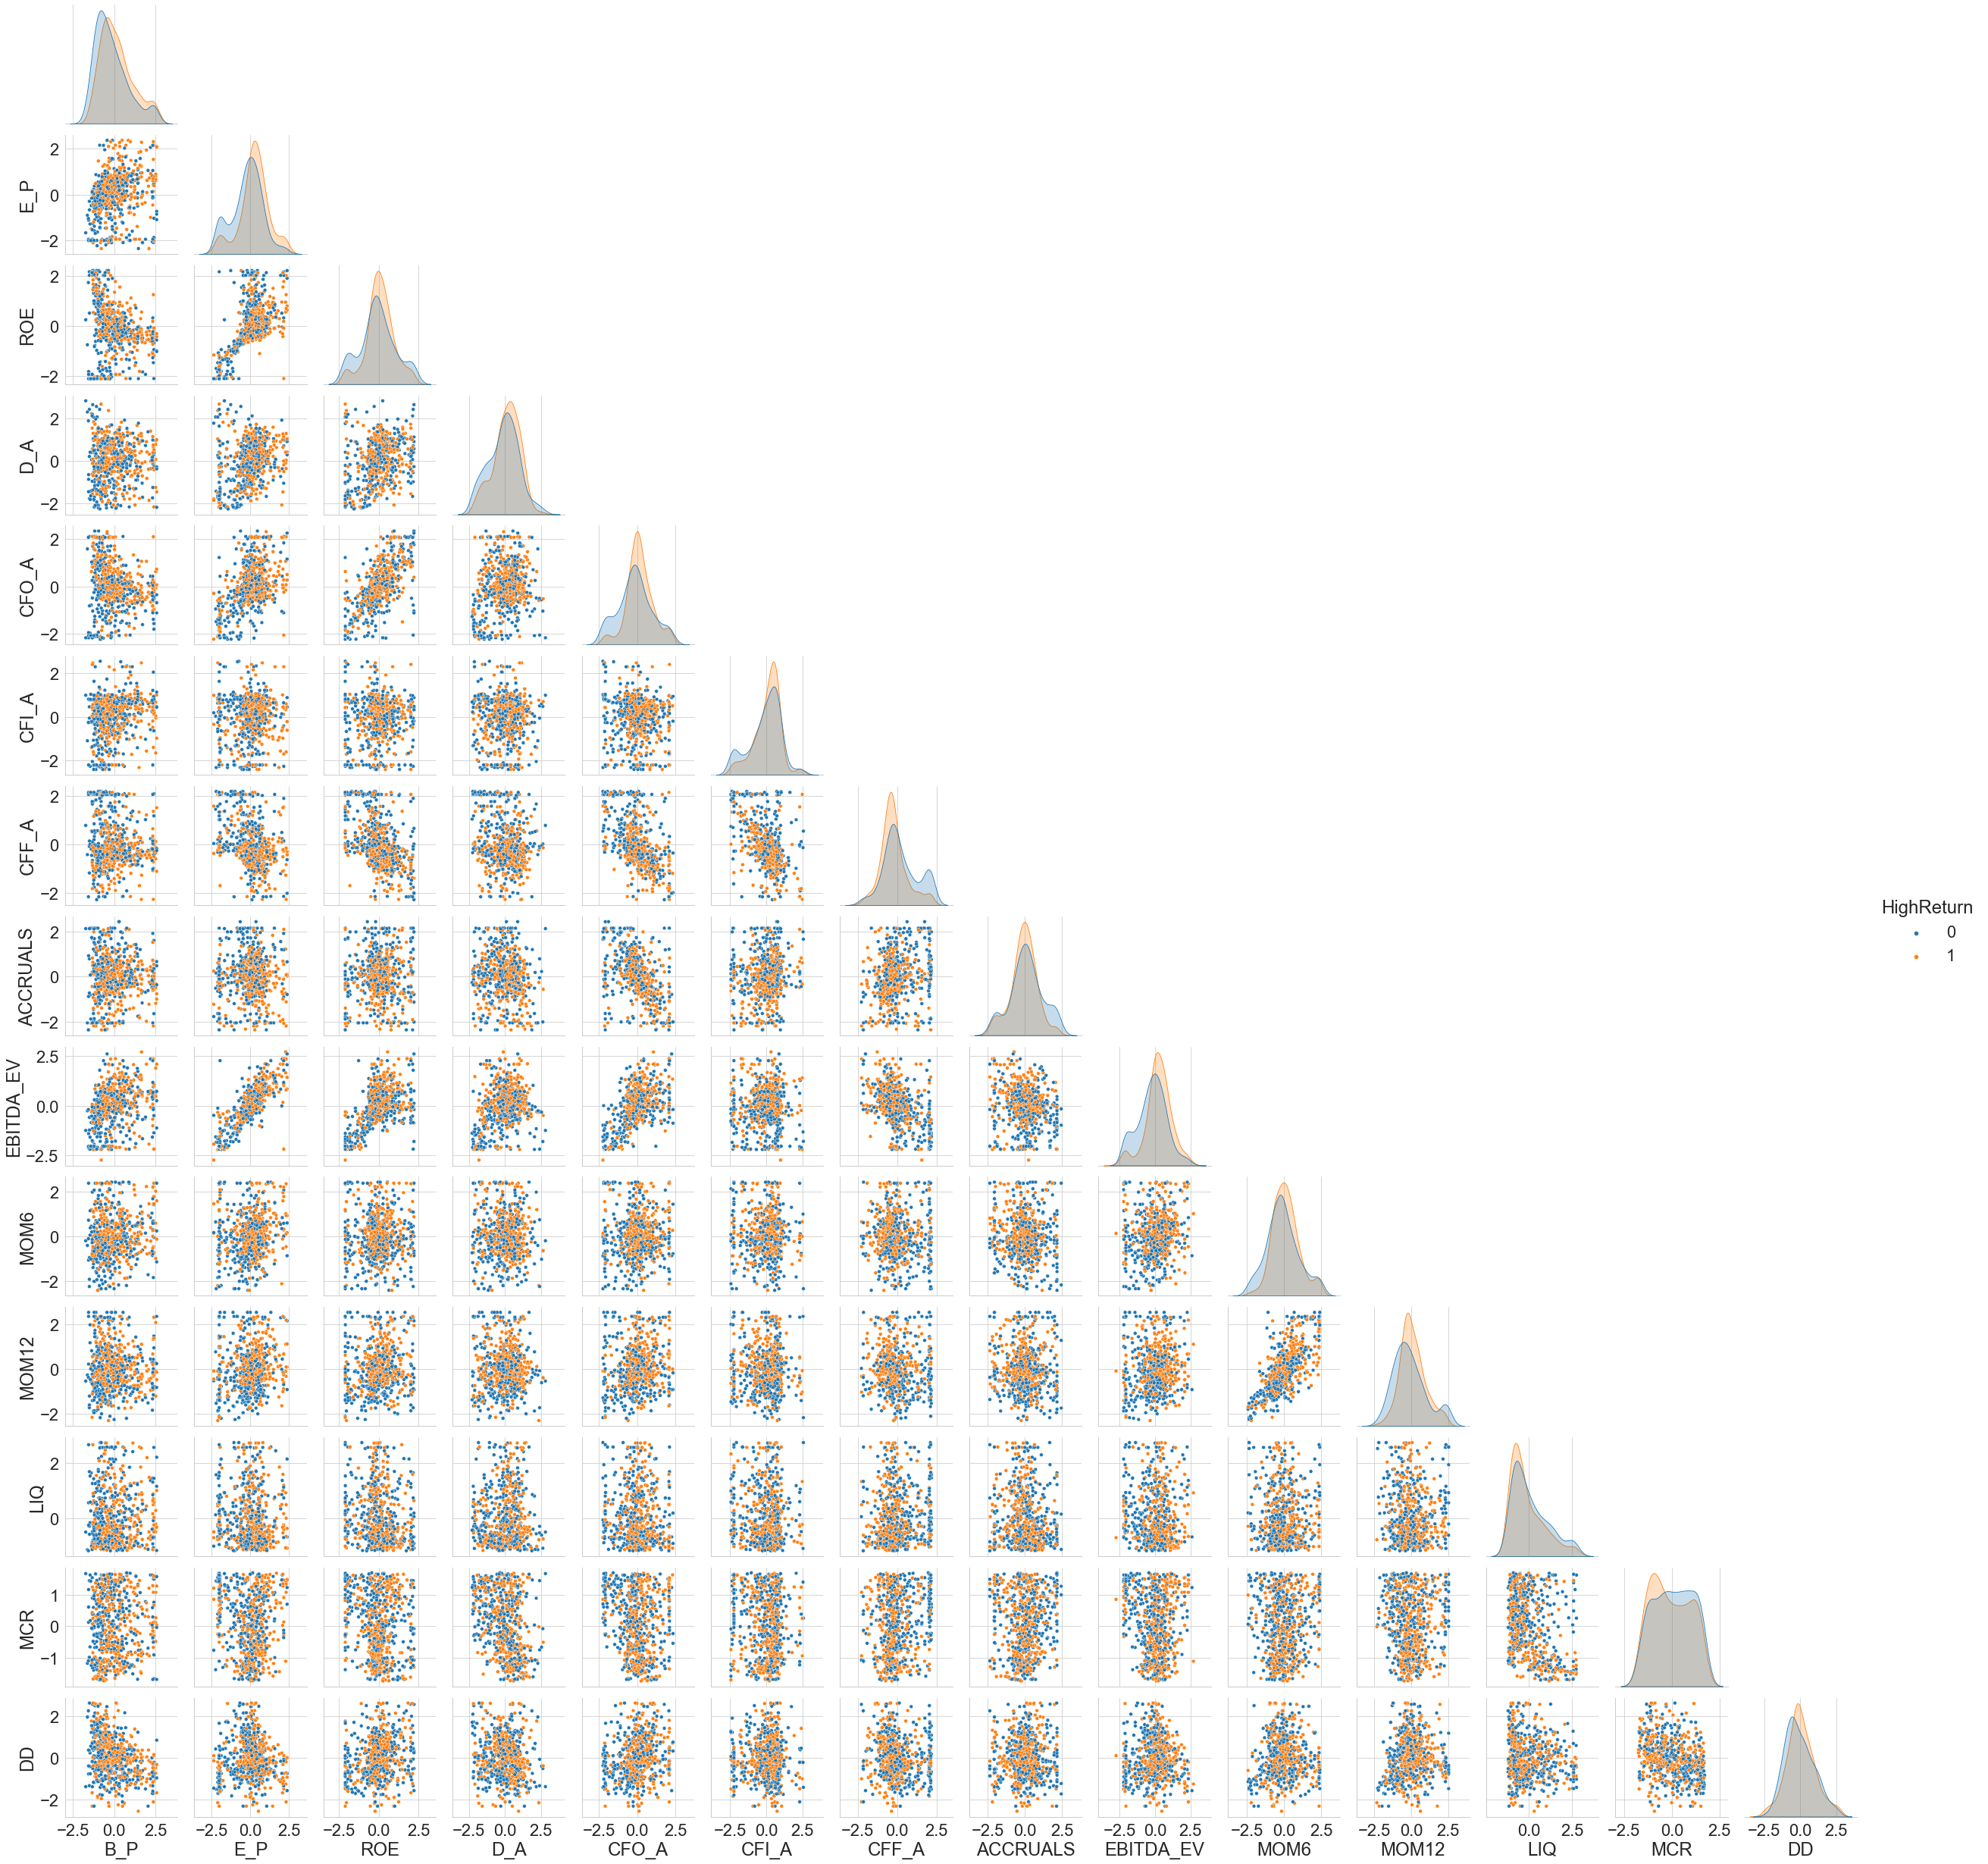

In [17]:
sns.set_context('paper', font_scale=2.5)
sns.set_style('whitegrid')
g=sns.pairplot(EDA_data.drop(columns=['StockID','ForecastYear','Return']),hue='HighReturn', corner=True)
plt.show()
g.savefig('pairplot2.jpeg')

In [19]:
from scipy.stats import kruskal

res=[]
list_of_features=['B_P','E_P','ROE','D_A','CFO_A','CFF_A','CFI_A','ACCRUALS','EBITDA_EV','MOM6','MOM12','LIQ','MCR','DD']
for f in list_of_features:
    df=EDA_data[[f,'Return']]
    mid=df[f].median()
    x1=df[df[f]>mid][['Return']].to_numpy()
    x2=df[df[f]<mid][['Return']].to_numpy()
    x1=x1.flatten()
    x2=x2.flatten()
    kw=kruskal(x1,x2).pvalue
    res.append(kruskal(x1,x2).pvalue)
df3=pd.DataFrame(res).set_axis(list_of_features)
df3.set_axis(['Kruskal-Wallis p-value'],axis='columns',inplace=True)
df3.style

,Kruskal-Wallis p-value
B_P,0.000201
E_P,0.000000
ROE,0.000171
D_A,0.001572
CFO_A,0.000060
CFF_A,0.000000
CFI_A,0.177766
ACCRUALS,0.017563
EBITDA_EV,0.000000
MOM6,0.003873


All features except for CFI_A, LIQ, MCR AND DD appear to have have some explanatory power over future returns

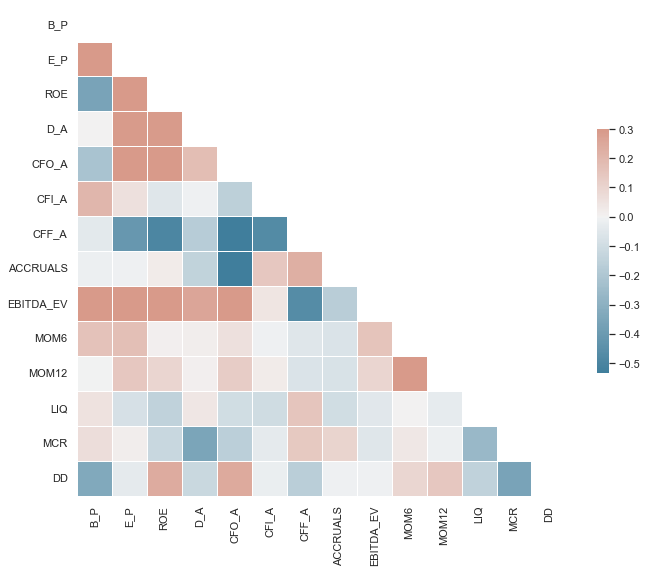

In [20]:
# correlation heatmap as per example at https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# we will use spearman (rank) correlation
sns.set_theme(style="white")
# Compute the correlation matrix
d=EDA_data.drop(columns=['StockID','ForecastYear','Return','HighReturn'])
corr = d.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
h=sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
f=h.get_figure()
f.savefig('heatmap.jpeg')

Cashflow from financing (CFF_A) is the feature that is most (negatively) related to the others. This feature might also be a bit noisy because it doesn't separate flows to equity and debt, especially dividends vs interest payments in the case of outflows (in an ideal world we might include equity issuance, dividend payments, debt issuance, interest payments etc as separate features). We are therefore happy to remove this feature, along with Cashflow from investing (CFI_A) and Liquidity (although liquidity may have some interactions with Momentum...).

We also no longer need the % returns column (daily stock returns are extracted later as part of the portfolio tests).

In [21]:
allData.drop(columns=['CFI_A','CFF_A','LIQ','MCR','DD','Return'],inplace=True)
allData.to_csv('allData.csv')
allData.head()

,StockID,B_P,E_P,ROE,D_A,CFO_A,ACCRUALS,EBITDA_EV,ForecastYear,MOM6,MOM12,HighReturn
0,2653,0.461836,0.051641,-0.008549,-0.207668,0.092830,-0.186066,0.099902,2001,0.219078,-0.062917,1
1,1258,0.225609,1.790828,0.609363,-0.324277,0.632213,0.349279,1.876328,2001,0.047808,0.103598,1
2,736,-1.230039,-0.586372,2.207310,0.381484,0.388183,1.989091,-0.873456,2001,0.856879,1.946755,1
3,2751,-0.540131,-0.056436,0.001548,0.259161,0.330483,-0.389080,-0.009323,2001,0.480499,0.140885,0
4,2427,2.506003,0.799488,-0.438838,0.762228,-0.068460,-0.442687,0.549158,2001,0.573430,-0.097906,1


HighReturn is the classification (i.e. above-median return in any calendar year) we want to predict using data from the previous year. We will cross-validate, train and test models using rolling five-year periods (e.g. classify returns as high or low for 2001 to 2005 using the previous year's features) and then (later) implement the model to predict the high/low classification the following year (e.g. 2006). We then roll the whole process forward one year at a time:

In [22]:
# function to tune hyperparameters and return a pipeline with optimal hyperparameters
def tunedModelPipeline(mdl, paramDists, X_tune, Y_tune, n_iter=None):
    new_paramDists={'clf__'+k:v for k,v in paramDists.items()}
    if not n_iter:
        n_iter=200 if len(paramDists)<3 else 500 # if searching over 3 parameters allow more iterations
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', mdl)])
    search=RandomizedSearchCV(pipe, new_paramDists, n_iter=n_iter, cv=5, random_state=0)
    search.fit(X_tune, Y_tune)
    pipe.set_params(**search.best_params_)
    return pipe

# function to calculate various performance metrics, on either training, test or outsample data
def modelPerformance(pipe, X_perf, Y_perf):
    y_hat=pipe.predict(X_perf)
    outperform_precision=precision_score(Y_perf, y_hat,pos_label=1)
    underperform_precision=precision_score(Y_perf, y_hat,pos_label=0)
    accuracy=accuracy_score(Y_perf, y_hat)
    return (accuracy, outperform_precision, underperform_precision)

In [89]:
# Here is a list of algorithms we will try with corresponding hyperparameters
# to be tuned via cross-validation

# Penalised Logistic Regresssion
lr=LogisticRegression(penalty='elasticnet', solver='saga', random_state=0)
lr_parameters={'C': loguniform(0.01, 100), 'l1_ratio': loguniform(0.01, 1)} # default penalty: L2; solver: lbfgs

#KNN
knn = KNeighborsClassifier(weights='distance')
knn_parameters={'n_neighbors':np.arange(1,100), 'metric':['euclidean', 'manhattan', 'chebyshev']}

# SVM with RBF kernel (polynomial kernel took too long to fit)
svm_rbf=svm.SVC(kernel='rbf',random_state=0)
svm_parameters={'C': loguniform(0.001, 10), \
                'gamma': loguniform(0.001, 10)}
              'max_depth':[2, 4, 6, 8, 10, 12]}

#AdaBoost
adb = AdaBoostClassifier(random_state=0, base_estimator=DecisionTreeClassifier(max_depth=1))
adb_parameters={'n_estimators':np.arange(1,100), 'learning_rate':loguniform(0.001, 0.2)}

# Gradient boosted trees
gbc=GradientBoostingClassifier(random_state=0)
gbc_parameters={'n_estimators':np.arange(1,100), 'learning_rate':loguniform(0.001, 0.2), 'max_depth':np.arange(1,5)}

# Random forest
rfc=RandomForestClassifier(random_state=0)
rfc_parameters={'max_features':np.arange(1,5), 'n_estimators':np.arange(1,100), 'max_depth':np.arange(1,5)}

model_list={'Penalised Logistic Regression':[lr, lr_parameters],\
           'KNN': [knn, knn_parameters],\
           'SVM (RBF)': [svm_rbf, svm_parameters],\
           'AdaBoost': [adb, adb_parameters],\
           'Random Forest': [rfc, rfc_parameters],\
           'Gradient Boosted Trees':[gbc, gbc_parameters],\
}

In [25]:
# function to split the data into rolling 5-year windows and then call the above functions
# to tune hyperparameters, fit and evaluate a given model on each 5-year window
def CrossValidateModel(mdl, y1, y2):
    [mdl_object, mdl_params]=model_list[mdl]
    fcast_years=[]
    best_params=[]
    training_accuracy=[]
    test_accuracy=[]
    outperform_precision=[]
    underperform_precision=[]
    for y in range(y1,y2+1):
        fcast_years.append("{:4}-{:4}".format(y,y+4))
        df=allData[(allData['ForecastYear']>=y) & (allData['ForecastYear']<=y+4)]
        X=df.drop(columns=['StockID','ForecastYear','HighReturn']).values # a numpy array
        Y=df['HighReturn'].values
        X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, stratify=Y, random_state=0)

        # tune hyperparameters and store the (fitted) model
        pipe=tunedModelPipeline(mdl_object, mdl_params, X_train, Y_train)
        best_params.append({k: pipe['clf'].get_params()[k] for k in mdl_params.keys()})
        pipe.fit(X_train, Y_train)
        
        # measure performance on training set & store the accuracy
        (trainAcc,outpPrec,undpPrec)=modelPerformance(pipe, X_train, Y_train)
        training_accuracy.append(trainAcc)

        # measure performance on test set & store the accuracy
        (testAcc,outpPrec,undpPrec)=modelPerformance(pipe, X_test, Y_test)
        test_accuracy.append(testAcc)
        # ideally, we should also evaluate the precision for each class as a measure of 'hit rate'
        outperform_precision.append(outpPrec)
        underperform_precision.append(undpPrec)
        
    report=pd.DataFrame({'Model':[mdl]*(y2-y1+1), 'Return years':fcast_years, 'Best params':best_params,\
            'training accuracy':training_accuracy,'test accuracy':test_accuracy, \
            'Outperform precision':outperform_precision, 'Underperform precision':underperform_precision})
           
    return report

In [48]:
# Logistic regression
LR=CrossValidateModel('Penalised Logistic Regression', 2001, 2008)
LR.to_csv('LR.csv')
LR

,Model,Return years,Best params,training accuracy,test accuracy,Outperform precision,Underperform precision
0,Penalised Logistic Regression,2001-2005,"{'C': 0.011933636175477524, 'l1_ratio': 0.0401...",0.625259,0.608696,0.615385,0.603448
1,Penalised Logistic Regression,2002-2006,"{'C': 0.012552057312500425, 'l1_ratio': 0.0136...",0.615534,0.601810,0.606742,0.598485
2,Penalised Logistic Regression,2003-2007,"{'C': 0.03388055680236167, 'l1_ratio': 0.01278...",0.608534,0.510823,0.494949,0.522727
3,Penalised Logistic Regression,2004-2008,"{'C': 0.011889379831773007, 'l1_ratio': 0.1718...",0.579965,0.522449,0.511111,0.536364
4,Penalised Logistic Regression,2005-2009,"{'C': 0.011622886871731429, 'l1_ratio': 0.0234...",0.569787,0.553435,0.556522,0.551020
5,Penalised Logistic Regression,2006-2010,"{'C': 0.06309371498229631, 'l1_ratio': 0.01089...",0.589474,0.555944,0.551020,0.561151
6,Penalised Logistic Regression,2007-2011,"{'C': 0.03796566727868301, 'l1_ratio': 0.09464...",0.590595,0.574194,0.560440,0.593750
7,Penalised Logistic Regression,2008-2012,"{'C': 0.14862132814482365, 'l1_ratio': 0.49875...",0.601290,0.597598,0.588889,0.607843


In [49]:
KNN=CrossValidateModel('KNN',2001,2008)
KNN.to_csv('KNN.csv')
KNN

,Model,Return years,Best params,training accuracy,test accuracy,Outperform precision,Underperform precision
0,KNN,2001-2005,"{'n_neighbors': 56, 'metric': 'manhattan'}",1.0,0.613527,0.588710,0.650602
1,KNN,2002-2006,"{'n_neighbors': 53, 'metric': 'euclidean'}",1.0,0.610860,0.594595,0.627273
2,KNN,2003-2007,"{'n_neighbors': 39, 'metric': 'manhattan'}",1.0,0.515152,0.500000,0.525926
3,KNN,2004-2008,"{'n_neighbors': 25, 'metric': 'manhattan'}",1.0,0.522449,0.510204,0.540816
4,KNN,2005-2009,"{'n_neighbors': 13, 'metric': 'manhattan'}",1.0,0.519084,0.513889,0.525424
5,KNN,2006-2010,"{'n_neighbors': 62, 'metric': 'manhattan'}",1.0,0.538462,0.538462,0.538462
6,KNN,2007-2011,"{'n_neighbors': 9, 'metric': 'manhattan'}",1.0,0.541935,0.541096,0.542683
7,KNN,2008-2012,"{'n_neighbors': 55, 'metric': 'euclidean'}",1.0,0.564565,0.551220,0.585938


In [50]:
SVM_RBF=CrossValidateModel('SVM (RBF)',2001,2008)
SVM_RBF.to_csv('SVM_RBF.csv')
SVM_RBF

,Model,Return years,Best params,training accuracy,test accuracy,Outperform precision,Underperform precision
0,SVM (RBF),2001-2005,"{'C': 0.7369511905048893, 'gamma': 0.038391829...",0.668737,0.642512,0.634615,0.650485
1,SVM (RBF),2002-2006,"{'C': 0.2965252740772563, 'gamma': 0.051888940...",0.646602,0.619910,0.621053,0.619048
2,SVM (RBF),2003-2007,"{'C': 0.7961907345193564, 'gamma': 0.101227270...",0.669759,0.571429,0.568421,0.573529
3,SVM (RBF),2004-2008,"{'C': 0.4645867951512474, 'gamma': 0.481450318...",0.724077,0.542857,0.542553,0.543046
4,SVM (RBF),2005-2009,"{'C': 0.5143587677210165, 'gamma': 0.012023527...",0.566502,0.553435,0.551181,0.555556
5,SVM (RBF),2006-2010,"{'C': 0.6161906336516408, 'gamma': 0.065188461...",0.619549,0.534965,0.527273,0.545455
6,SVM (RBF),2007-2011,"{'C': 3.3451283690722042, 'gamma': 0.211393432...",0.796680,0.561290,0.548913,0.579365
7,SVM (RBF),2008-2012,"{'C': 0.6161906336516408, 'gamma': 0.065188461...",0.623226,0.570571,0.563536,0.578947


In [110]:
# AdaBoost : an ensemble of tree stumps (depth 1)
ADB=CrossValidateModel('AdaBoost',2001,2008)
ADB.to_csv('ADB.csv')
ADB

,Model,Return years,Best params,training accuracy,test accuracy,Outperform precision,Underperform precision
0,AdaBoost,2001-2005,"{'n_estimators': 49, 'learning_rate': 0.035696...",0.689441,0.603865,0.590909,0.618557
1,AdaBoost,2002-2006,"{'n_estimators': 68, 'learning_rate': 0.024376...",0.656311,0.610860,0.598131,0.622807
2,AdaBoost,2003-2007,"{'n_estimators': 12, 'learning_rate': 0.170435...",0.636364,0.532468,0.522222,0.539007
3,AdaBoost,2004-2008,"{'n_estimators': 42, 'learning_rate': 0.040296...",0.616872,0.551020,0.529412,0.600000
4,AdaBoost,2005-2009,"{'n_estimators': 19, 'learning_rate': 0.026428...",0.569787,0.572519,0.564286,0.581967
5,AdaBoost,2006-2010,"{'n_estimators': 54, 'learning_rate': 0.097777...",0.624060,0.527972,0.527132,0.528662
6,AdaBoost,2007-2011,"{'n_estimators': 12, 'learning_rate': 0.170435...",0.594744,0.548387,0.540698,0.557971
7,AdaBoost,2008-2012,"{'n_estimators': 40, 'learning_rate': 0.036485...",0.611613,0.558559,0.542601,0.590909


In [86]:
# Random forest classifier
RFC=CrossValidateModel('Random Forest',2001,2008)
RFC.to_csv('RFC.csv')
RFC

,Model,Return years,Best params,training accuracy,test accuracy,Outperform precision,Underperform precision
0,Random Forest,2001-2005,"{'max_features': 2, 'n_estimators': 23, 'max_d...",0.679089,0.618357,0.611650,0.625000
1,Random Forest,2002-2006,"{'max_features': 1, 'n_estimators': 35, 'max_d...",0.714563,0.597285,0.584906,0.608696
0,Random Forest,2003-2007,"{'max_features': 1, 'n_estimators': 19, 'max_d...",0.660482,0.558442,0.558140,0.558621
1,Random Forest,2004-2008,"{'max_features': 3, 'n_estimators': 18, 'max_d...",0.720562,0.571429,0.553957,0.594340
2,Random Forest,2005-2009,"{'max_features': 3, 'n_estimators': 32, 'max_d...",0.586207,0.576336,0.566434,0.588235
3,Random Forest,2006-2010,"{'max_features': 3, 'n_estimators': 1, 'max_de...",0.612030,0.534965,0.546392,0.529101
4,Random Forest,2007-2011,"{'max_features': 1, 'n_estimators': 26, 'max_d...",0.663900,0.535484,0.531646,0.539474
5,Random Forest,2008-2012,"{'max_features': 3, 'n_estimators': 32, 'max_d...",0.601290,0.564565,0.552764,0.582090


In [93]:
GBC=CrossValidateModel('Gradient Boosted Trees',2001,2008)
GBC.to_csv('GBC.csv')
GBC

,Model,Return years,Best params,training accuracy,test accuracy,Outperform precision,Underperform precision
0,Gradient Boosted Trees,2001-2005,"{'n_estimators': 97, 'learning_rate': 0.012975...",0.708075,0.599034,0.590476,0.607843
1,Gradient Boosted Trees,2002-2006,"{'n_estimators': 34, 'learning_rate': 0.097440...",0.728155,0.574661,0.560748,0.587719
0,Gradient Boosted Trees,2003-2007,"{'n_estimators': 94, 'learning_rate': 0.035490...",0.640074,0.558442,0.552083,0.562963
1,Gradient Boosted Trees,2004-2008,"{'n_estimators': 79, 'learning_rate': 0.069992...",0.838313,0.538776,0.528000,0.550000
2,Gradient Boosted Trees,2005-2009,"{'n_estimators': 2, 'learning_rate': 0.1708084...",0.569787,0.572519,0.564286,0.581967
3,Gradient Boosted Trees,2006-2010,"{'n_estimators': 56, 'learning_rate': 0.013274...",0.756391,0.545455,0.546154,0.544872
4,Gradient Boosted Trees,2007-2011,"{'n_estimators': 50, 'learning_rate': 0.004336...",0.663900,0.503226,0.500000,0.508333
5,Gradient Boosted Trees,2008-2012,"{'n_estimators': 82, 'learning_rate': 0.023120...",0.615484,0.558559,0.542601,0.590909


In [19]:
### previous version
import ast
def implementModelOutOfSample(df, y1, y2, fromCSV=False):
# implement the model by predicting out of sample, using the best cross-validated model
# if fromCSV=True, params need to be converted from string to dict
    outOfSampleAcc=[]
    dfs=[]
    for i in range(y2-y1+1):
        yrs=(i+y1-5,i+y1-1,i+y1) # start & end years of train/test data & forecast year
        yrsKey="{:4}-{:4}".format(yrs[0],yrs[1])    # used to identify the fit model fit over a time period; e.g. 2001-2005

        # get best cross-validated model type, if applicable
        mdl=df['Model'][df['Return years']==yrsKey].item()
        mdltype=model_list[mdl][0]
        clf=mdltype # create appropriate sklearn classifier object
        if hasattr(clf, 'probability'):
            clf.set_params(**{'probability':True})

        # get cross-validated hyperparameters
        params=df['Best params'][df['Return years']==yrsKey].item()
        if fromCSV:
            params=ast.literal_eval(params) # necessary for dataframes stored in & read from csv; the dict gets read as a string
        clf.set_params(**params)

        # fit the model using all the insample data
        df1=allData[(allData['ForecastYear']>=yrs[0]) & (allData['ForecastYear']<=yrs[1])]
        X=df1.drop(columns=['StockID','ForecastYear','HighReturn']).values # X is a numpy array
        Y=df1['HighReturn'].values
        X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
        clf.fit(X,Y)

        # now use the model to predict the following year's (out-of-sample) classification e.g. 2006
        df2=allData[allData['ForecastYear']==yrs[2]]
        X2=df2.drop(columns=['StockID','ForecastYear','HighReturn']).values # X is a numpy array
        Y2=df2['HighReturn'].values
        X2 = preprocessing.StandardScaler().fit(X2).transform(X2.astype(float))
        Y2_hat=clf.predict(X2)
        Y2_prob=clf.predict_proba(X2)
        outOfSampleAcc.append(accuracy_score(Y2, Y2_hat))
        z=pd.concat([pd.Series([mdl]*len(Y2_hat)), pd.Series([yrs[2]]*len(Y2_hat)), pd.Series(df2['StockID'].values), pd.Series(Y2_prob[:,1]), pd.Series(Y2)],axis=1)
        z.columns=['Model','Forecast Year', 'StockID', 'Prob', 'Actual']
        dfs.append(z)
    outOfSamplePredictions=pd.concat(dfs)
    return [outOfSamplePredictions, outOfSampleAcc] # probability predictions and yearly accuracy

In [94]:
### new version
### we won't stuff around with reading from CSV

#import ast

#def implementModelOutOfSample(df, y1, y2, fromCSV=False):
def implementModelOutOfSample(df, y1, y2):
# implement the model by predicting out of sample, using the best cross-validated model
# if fromCSV=True, params need to be converted from string to dict
    outOfSampleAcc=[]
    dfs=[]
    for i in range(y2-y1+1):
        yrs=(i+y1-5,i+y1-1,i+y1) # start & end years of train/test data & forecast year
        yrsKey="{:4}-{:4}".format(yrs[0],yrs[1])    # used to identify the fit model fit over a time period; e.g. 2001-2005

        # get best cross-validated model type, if applicable
        mdl=df['Model'][df['Return years']==yrsKey].item()
        mdltype=model_list[mdl][0]
        clf=mdltype # create appropriate sklearn classifier object
        if hasattr(clf, 'probability'):
            clf.set_params(**{'probability':True})

        # get cross-validated hyperparameters
        params=df['Best params'][df['Return years']==yrsKey].item()
#        if fromCSV:
#            params=ast.literal_eval(params) # necessary for dataframes stored in & read from csv; the dict gets read as a string
        clf.set_params(**params)

        # fit the model using all the insample data
        df1=allData[(allData['ForecastYear']>=yrs[0]) & (allData['ForecastYear']<=yrs[1])]
        X=df1.drop(columns=['StockID','ForecastYear','HighReturn']).values # X is a numpy array
        Y=df1['HighReturn'].values
        X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
        clf.fit(X,Y)

        # now use the model to predict the following year's (out-of-sample) classification e.g. 2006
        df2=allData[allData['ForecastYear']==yrs[2]]
        X2=df2.drop(columns=['StockID','ForecastYear','HighReturn']).values # X is a numpy array
        Y2=df2['HighReturn'].values
        X2 = preprocessing.StandardScaler().fit(X2).transform(X2.astype(float))
        Y2_hat=clf.predict(X2)
        Y2_prob=clf.predict_proba(X2)
        outOfSampleAcc.append(accuracy_score(Y2, Y2_hat))
        z=pd.concat([pd.Series([mdl]*len(Y2_hat)), pd.Series([yrs[2]]*len(Y2_hat)), pd.Series(df2['StockID'].values), pd.Series(Y2_prob[:,1]), pd.Series(Y2)],axis=1)
        z.columns=['Model','Forecast Year', 'StockID', 'Prob', 'Actual']
        dfs.append(z)
    outOfSamplePredictions=pd.concat(dfs)
    return [outOfSamplePredictions, outOfSampleAcc] # probability predictions and yearly accuracy

The models can take a long time to fit. To save time the option exists to read in previously-fitted model specifications which were saved to csv files using pd.read_csv.

In [115]:
#Produce out-of-sample predictions using each model
LR_pred=implementModelOutOfSample(LR, 2006, 2013)
KNN_pred=implementModelOutOfSample(KNN, 2006, 2013)
SVM_RBF_pred=implementModelOutOfSample(SVM_RBF, 2006, 2013)
ADB_pred=implementModelOutOfSample(ADB, 2006, 2013)
GBC_pred=implementModelOutOfSample(GBC, 2006, 2013)
RFC_pred=implementModelOutOfSample(RFC, 2006, 2013)

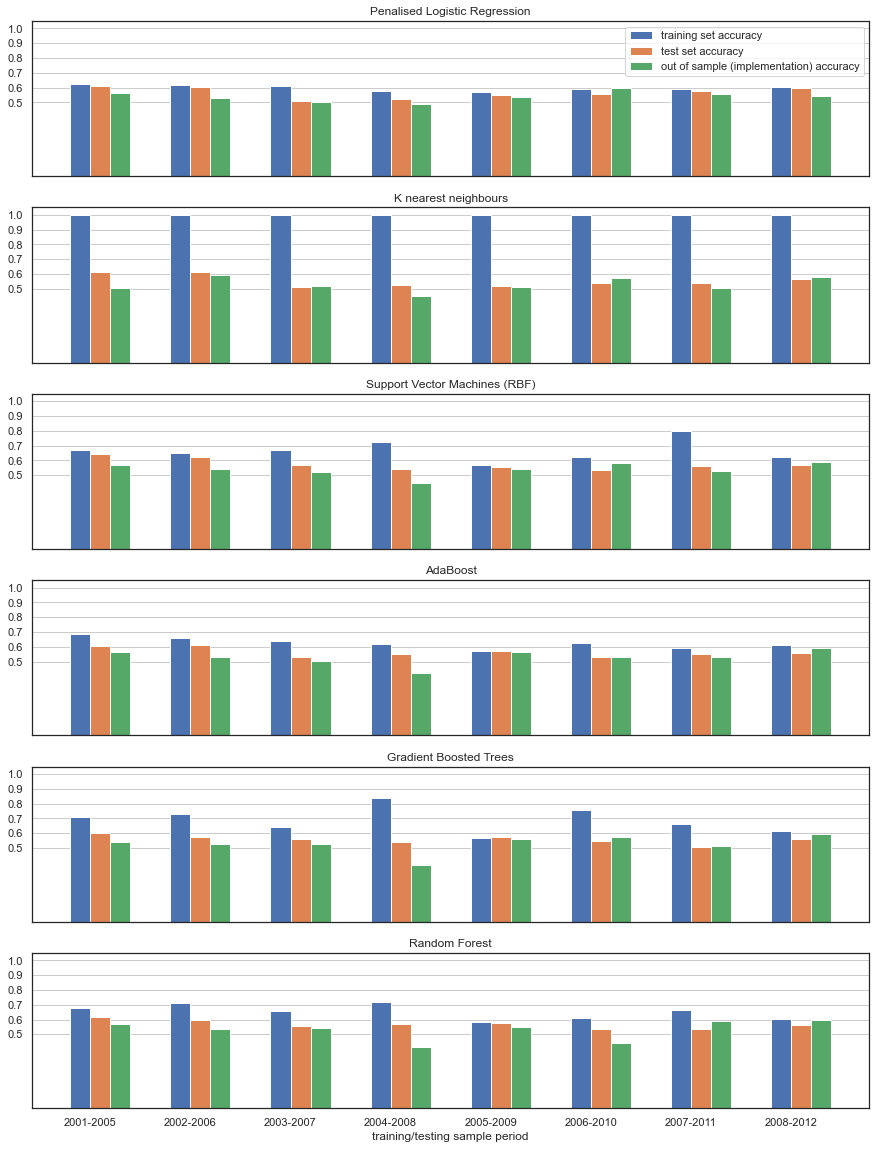

In [117]:
# Now report on cross validation accuracy on training and test sets and out-of-sample accuracy
models=[LR, KNN, SVM_RBF, ADB, GBC, RFC]
outOfSample=[LR_pred, KNN_pred, SVM_RBF_pred, ADB_pred, GBC_pred, RFC_pred]
mdl_titles=['Penalised Logistic Regression', 'K nearest neighbours', 'Support Vector Machines (RBF)', \
            'AdaBoost', 'Gradient Boosted Trees', 'Random Forest']
x_lbls=[str(y)+'-'+str(y+4) for y in np.arange(2001,2009)]
index = np.arange(8)
bar_width = 0.2
f, axs = plt.subplots(len(models),1, figsize=(15,20),sharex='col')
for i,m in enumerate(models):
    m=m.sort_values(by='Return years') # ensure df's are in order
    axs[i].bar(index-0.1, m['training accuracy'],-bar_width, align='edge', tick_label=x_lbls, label='training set accuracy')
    axs[i].bar(index, m['test accuracy'],bar_width, align='center', label='test set accuracy')
    oos=outOfSample[i]
    axs[i].bar(index+0.1, oos[1],bar_width, align='edge', label='out of sample (implementation) accuracy')
    axs[i].set_ylim([0,1.05])
    axs[i].set_title(mdl_titles[i])
    axs[i].grid(axis='y')
    axs[i].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
    plt.xlabel('training/testing sample period')
    if i==0:
        axs[i].legend()
f.savefig('accuracy.jpeg')

In [118]:
# function to plot portfolios based on ML algorithms

def plot_ML_based_portfolios(src, desc):
    yearRange=[2006, 2013]
    longPortfolios=[]
    shortPortfolios=[]
    
    for y in np.arange(yearRange[0],yearRange[1]+1):
        df=src[src['Forecast Year']==y]
        q67=df['Prob'].quantile(q=0.67)
        q33=df['Prob'].quantile(q=0.33)
        lngPort=df['StockID'][df['Prob']>=q67]
        shrtPort=df['StockID'][df['Prob']<=q33]
        longPortfolios.append(lngPort)
        shortPortfolios.append(shrtPort)
    portValues=calcAllPortfolioValues(cnxn, zip(longPortfolios,shortPortfolios,list(range(yearRange[0],yearRange[1]+1))))
    #calculate portfolio returns
    portReturns=calcPortfolioReturns(portValues)

    indexData=extractIndexData(cnxn, yearRange) # extract benchmark total return (S&P200 accumulation) index
    indexData=indexData.divide((indexData['AccumIndex'][0], 1)) # reset so that starting value=1

    # calculate performance stats
    perfStats=calcPerformanceStats(portReturns, indexData['DailyRet'])

    # plot the portfolio value and display the performance stats
    Factors=[desc+' probability']
    LongPortfolioDesc=[1]
    fig=plotPortfolioValues(portValues, indexData['AccumIndex'], Factors, LongPortfolioDesc, perfStats)
    return fig

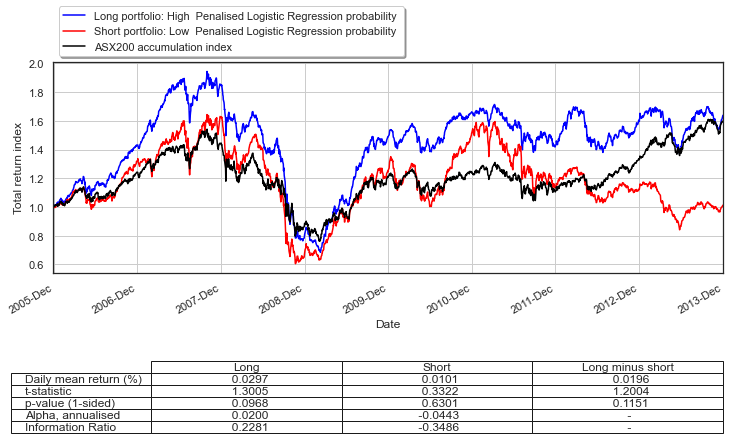

In [119]:
fig=plot_ML_based_portfolios(LR_pred[0], ' Penalised Logistic Regression')
fig.savefig('LR.jpeg')

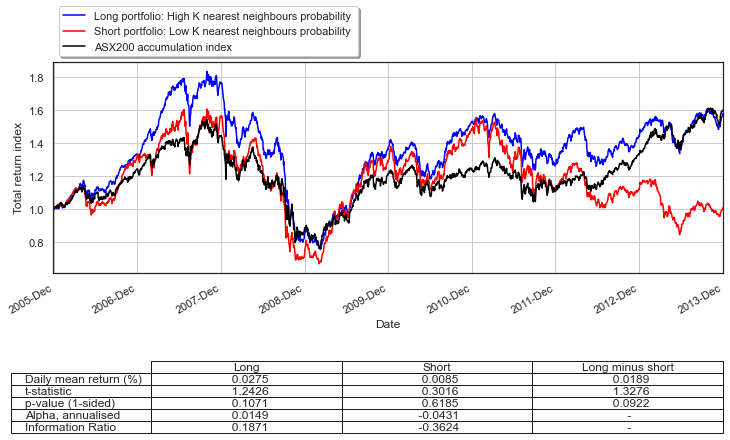

In [120]:
fig=plot_ML_based_portfolios(KNN_pred[0], 'K nearest neighbours')
fig.savefig('KNN.jpeg')

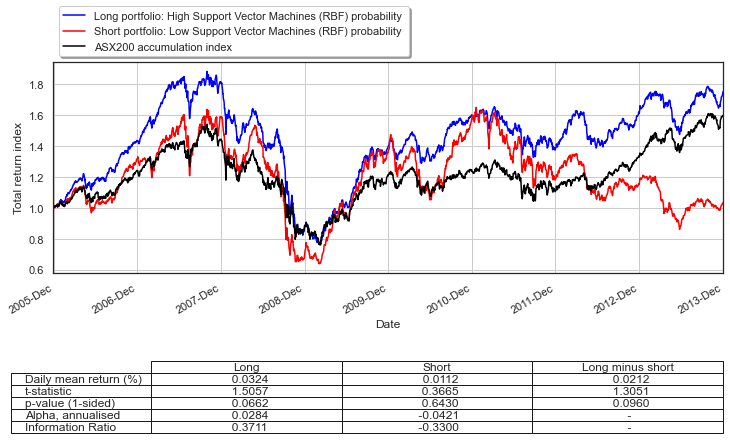

In [121]:
fig=plot_ML_based_portfolios(SVM_RBF_pred[0], 'Support Vector Machines (RBF)')
fig.savefig('SVM.jpeg')

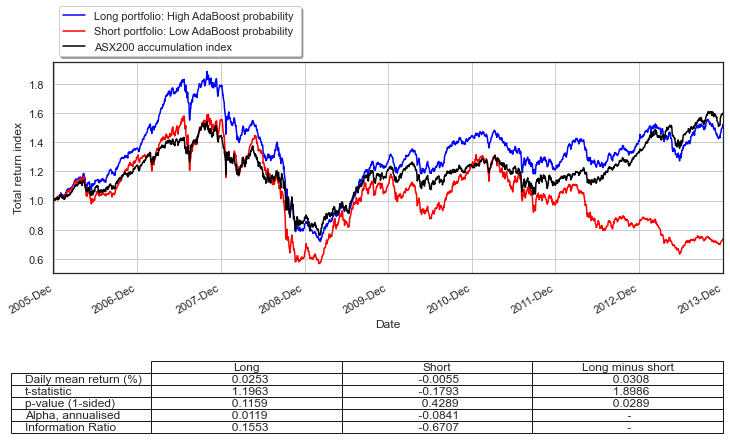

In [122]:
fig=plot_ML_based_portfolios(ADB_pred[0], 'AdaBoost')
fig.savefig('ADB.jpeg')

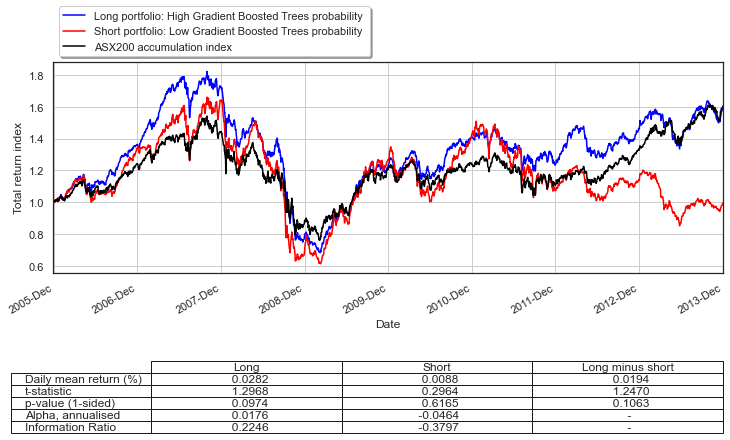

In [123]:
fig=plot_ML_based_portfolios(GBC_pred[0], 'Gradient Boosted Trees')
fig.savefig('GBC.jpeg')

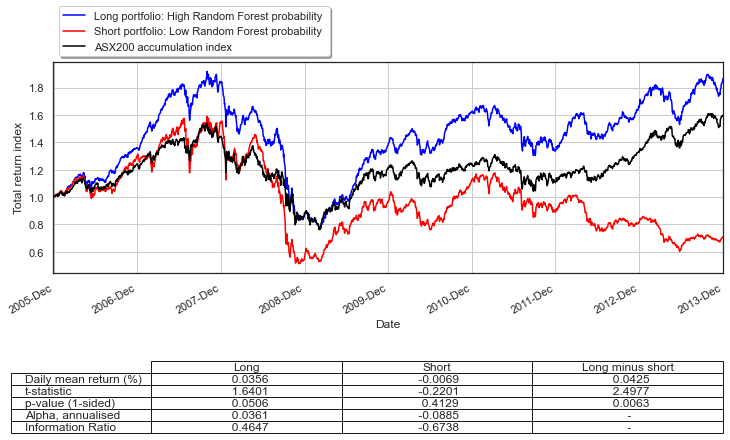

In [124]:
fig=plot_ML_based_portfolios(RFC_pred[0], 'Random Forest')
fig.savefig('RFC.jpeg')

Only the Random Forests algorithm was able to generate a Long portfolio that outperformed the benchmark. All of the algorithms showed some ability to select a short portfolio that underperformed the benchmark.

We will now try a naive model simply based on a few of the ratios that looked important from our exploratory data analysis:
- Book to price
- Earnings to price
- Return on Equity
- Cashflow from operations to Assets
- Accruals (multiplied by -1 becaue it has an inverse relationship with returns)
- EBITDA to EV
- 6-month price Momentum
- 12-month price momentum
<br><br>We simply add the z-scores 

In [136]:
naiveData=allData[['StockID','B_P','E_P','ROE','CFO_A','ACCRUALS','EBITDA_EV','MOM6','MOM12','ForecastYear','HighReturn']]
naiveData.loc[:,'ACCRUALS'] *= -1 # generates SettingWithCopyWarning warning
factors=['B_P','E_P','ROE','CFO_A','ACCRUALS','EBITDA_EV','MOM6','MOM12']
list_of_dfs=[]
for y in range(2001,2014):
    df=naiveData[naiveData['ForecastYear']==y]
    df.insert(len(df.columns),'rawScore',df[factors].sum(axis=1))
    df.insert(len(df.columns),'Prob',df['rawScore'].rank(pct=True))
    list_of_dfs.append(df[['StockID','ForecastYear','Prob','HighReturn']])
naiveModel=pd.concat(list_of_dfs)
naiveModel.to_csv('naiveModel.csv')
naiveModel.head()

C:\Users\stuli\AppData\Local\Temp\ipykernel_26712\1260310941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  naiveData.loc[:,'ACCRUALS'] *= -1 # generates SettingWithCopyWarning warning


,StockID,ForecastYear,Prob,HighReturn
0,2653,2001,0.581818,1
1,1258,2001,0.890909,1
2,736,2001,0.563636,1
3,2751,2001,0.554545,0
4,2427,2001,0.863636,1


In [126]:
naiveData=allData[['StockID','B_P','E_P','ROE','CFO_A','ACCRUALS','EBITDA_EV','MOM6','MOM12','ForecastYear','HighReturn']]
naiveData.head()

,StockID,B_P,E_P,ROE,CFO_A,ACCRUALS,EBITDA_EV,MOM6,MOM12,ForecastYear,HighReturn
0,2653,0.437845,0.102477,0.032911,0.157703,-0.226800,0.074598,0.115100,-0.145057,2001,1
1,1258,0.209226,1.790342,0.582372,0.635420,0.264361,1.469000,-0.050148,0.018820,2001,1
2,736,-1.199539,-0.516709,2.097504,0.419289,1.923240,-0.689437,0.730472,1.832786,2001,1
3,2751,-0.531851,-0.002411,0.041889,0.368186,-0.413058,-0.011138,0.367328,0.055517,2001,0
4,2427,2.628821,0.828256,-0.349712,0.014853,-0.462241,0.427241,0.456991,-0.179492,2001,1


In [135]:
#naiveData.loc[:,'ACCRUALS'] *= -1
naiveData['ACCRUALS'] = naiveData['ACCRUALS'].apply(lambda x: x*-1)

C:\Users\stuli\AppData\Local\Temp\ipykernel_26712\440330177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  naiveData['ACCRUALS'] = naiveData['ACCRUALS'].apply(lambda x: x*-1)


In [133]:
naiveData.head()

,StockID,B_P,E_P,ROE,CFO_A,ACCRUALS,EBITDA_EV,MOM6,MOM12,ForecastYear,HighReturn
0,2653,0.437845,0.102477,0.032911,0.157703,0.226800,0.074598,0.115100,-0.145057,2001,1
1,1258,0.209226,1.790342,0.582372,0.635420,-0.264361,1.469000,-0.050148,0.018820,2001,1
2,736,-1.199539,-0.516709,2.097504,0.419289,-1.923240,-0.689437,0.730472,1.832786,2001,1
3,2751,-0.531851,-0.002411,0.041889,0.368186,0.413058,-0.011138,0.367328,0.055517,2001,0
4,2427,2.628821,0.828256,-0.349712,0.014853,0.462241,0.427241,0.456991,-0.179492,2001,1


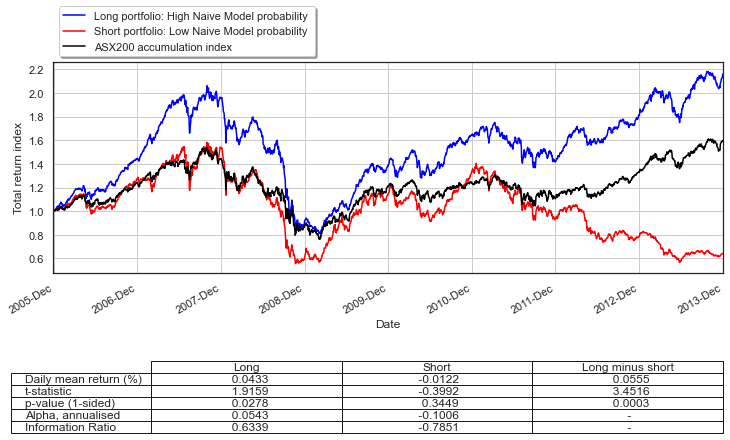

In [137]:
# script to plot portfolios based on the naive model
desc='Naive Model'
yearRange=[2006, 2013]
longPortfolios=[]
shortPortfolios=[]
    
for y in np.arange(yearRange[0],yearRange[1]+1):
    df=naiveModel[naiveModel['ForecastYear']==y]
    q67=df['Prob'].quantile(q=0.67)
    q33=df['Prob'].quantile(q=0.33)
    lngPort=df['StockID'][df['Prob']>=q67]
    shrtPort=df['StockID'][df['Prob']<=q33]
    longPortfolios.append(lngPort)
    shortPortfolios.append(shrtPort)

portValues=calcAllPortfolioValues(cnxn, zip(longPortfolios,shortPortfolios,list(range(yearRange[0],yearRange[1]+1))))
#calculate portfolio returns
portReturns=calcPortfolioReturns(portValues)

indexData=extractIndexData(cnxn, yearRange) # extract benchmark total return (S&P200 accumulation) index
indexData=indexData.divide((indexData['AccumIndex'][0], 1)) # reset so that starting value=1

# calculate performance stats
perfStats=calcPerformanceStats(portReturns, indexData['DailyRet'])

# plot the portfolio value and display the performance stats
Factors=[desc+' probability']
LongPortfolioDesc=[1]
fig=plotPortfolioValues(portValues, indexData['AccumIndex'], Factors, LongPortfolioDesc, perfStats)
fig.savefig('Naive.jpeg')